# Multilevel intercepts
+ other features

In [1]:
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

%matplotlib inline

# Train/Test data
train = pd.read_csv('../data/raw/train.csv').assign(data_type = 'train')
test = pd.read_csv('../data/raw/test.csv').assign(data_type = 'test')

# Want to ensure the encodings of the neighbourhoods as indexes are consistent
df_full = train.append(test, ignore_index = True)
df_full['neighbourhood'] = df_full['Neighborhood'].astype('category').cat.codes+1
#df_full['OverallQual'] = df_full['OverallQual'].astype('category').cat.codes+1

# Log variables
df_full['log_sales_price'] = np.log(df_full['SalePrice'])
df_full['log_lot_area'] = np.log(df_full['LotArea'])

# Train/test split
train = df_full.loc[df_full['data_type'] == 'train'].copy()
test = df_full.loc[df_full['data_type'] == 'test'].copy()

# Center and scale predictor (train)
train['log_lot_area_z'] = (train[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target (train)
train['log_sales_price_std'] = train['log_sales_price']/train['log_sales_price'].mean()

# Center and scale predictor using training data mean and std
test['log_lot_area_z'] = (test[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target using training data mean
test['log_sales_price_std'] = test['log_sales_price']/train['log_sales_price'].mean()

In [2]:
def standardise_predictor(column):
    std_pred_train = (train[['{}'.format(column)]] - train[['{}'.format(column)]].mean()) / train[['{}'.format(column)]].std()
    std_pred_test = (test[['{}'.format(column)]] - train[['{}'.format(column)]].mean()) / train[['{}'.format(column)]].std()
    
    return std_pred_train, std_pred_test

In [3]:
train['log_lot_area_z'] , test['log_lot_area_z'] = standardise_predictor(column = 'log_lot_area')
train['BedroomAbvGr_z'] , test['BedroomAbvGr_z'] = standardise_predictor(column = 'BedroomAbvGr')
train['OverallCond_z'] , test['OverallCond_z'] = standardise_predictor(column = 'OverallCond')
train['OverallQual_z'] , test['OverallQual_z'] = standardise_predictor(column = 'OverallQual')
train['GrLivArea_z'] , test['GrLivArea_z'] = standardise_predictor(column = 'GrLivArea')
train['1stFlrSF_z'], test['1stFlrSF_z'] = standardise_predictor(column = '1stFlrSF')
train['2ndFlrSF_z'], test['2ndFlrSF_z'] = standardise_predictor(column = '2ndFlrSF')


In [12]:
X = pd.concat([train['BedroomAbvGr_z'],
               train['OverallCond_z'], 
               train['OverallQual_z'],
               train['GrLivArea_z'],
              train['1stFlrSF_z'],
              train['2ndFlrSF_z']],
               axis = 1)

X_test = pd.concat([test['BedroomAbvGr_z'],
                    test['OverallCond_z'], 
                    test['OverallQual_z'],
                    test['GrLivArea_z'],
                    test['1stFlrSF_z'],
                    test['2ndFlrSF_z']],
                   axis = 1)

In [20]:
# Import multilevel model
multilevel_slopes = pystan.StanModel(file = '../src/models/multilevel_int_extra_features.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e458572c8ab50386417ce2fcbbabb78f NOW.


In [47]:
data_check = dict(N = len(train),
                  N_test = len(test),
                  P = len(X.columns),
                  P_test = len(X_test.columns),
                  X = X,
                  X_test = X_test,
                  log_sales_price = train['log_sales_price_std'],
                  neighbourhood = train['neighbourhood'],
                  N_neighbourhood = len(train['Neighborhood'].unique()),
                  neighbourhood_test = test['neighbourhood'],
                  run_estimation = 0)

fit_model_check = multilevel_slopes.sampling(data=data_check)
df_model_check = fit_model_check.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Prior predcitive checks

In [48]:
import arviz as az
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

fit_model_check.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False, 
                                                        xlim = (-10, 10));

AttributeError: 'stanfit4anon_model_0e5d8e8d29bd46283fde90c526d9a5c' object has no attribute 'filter'

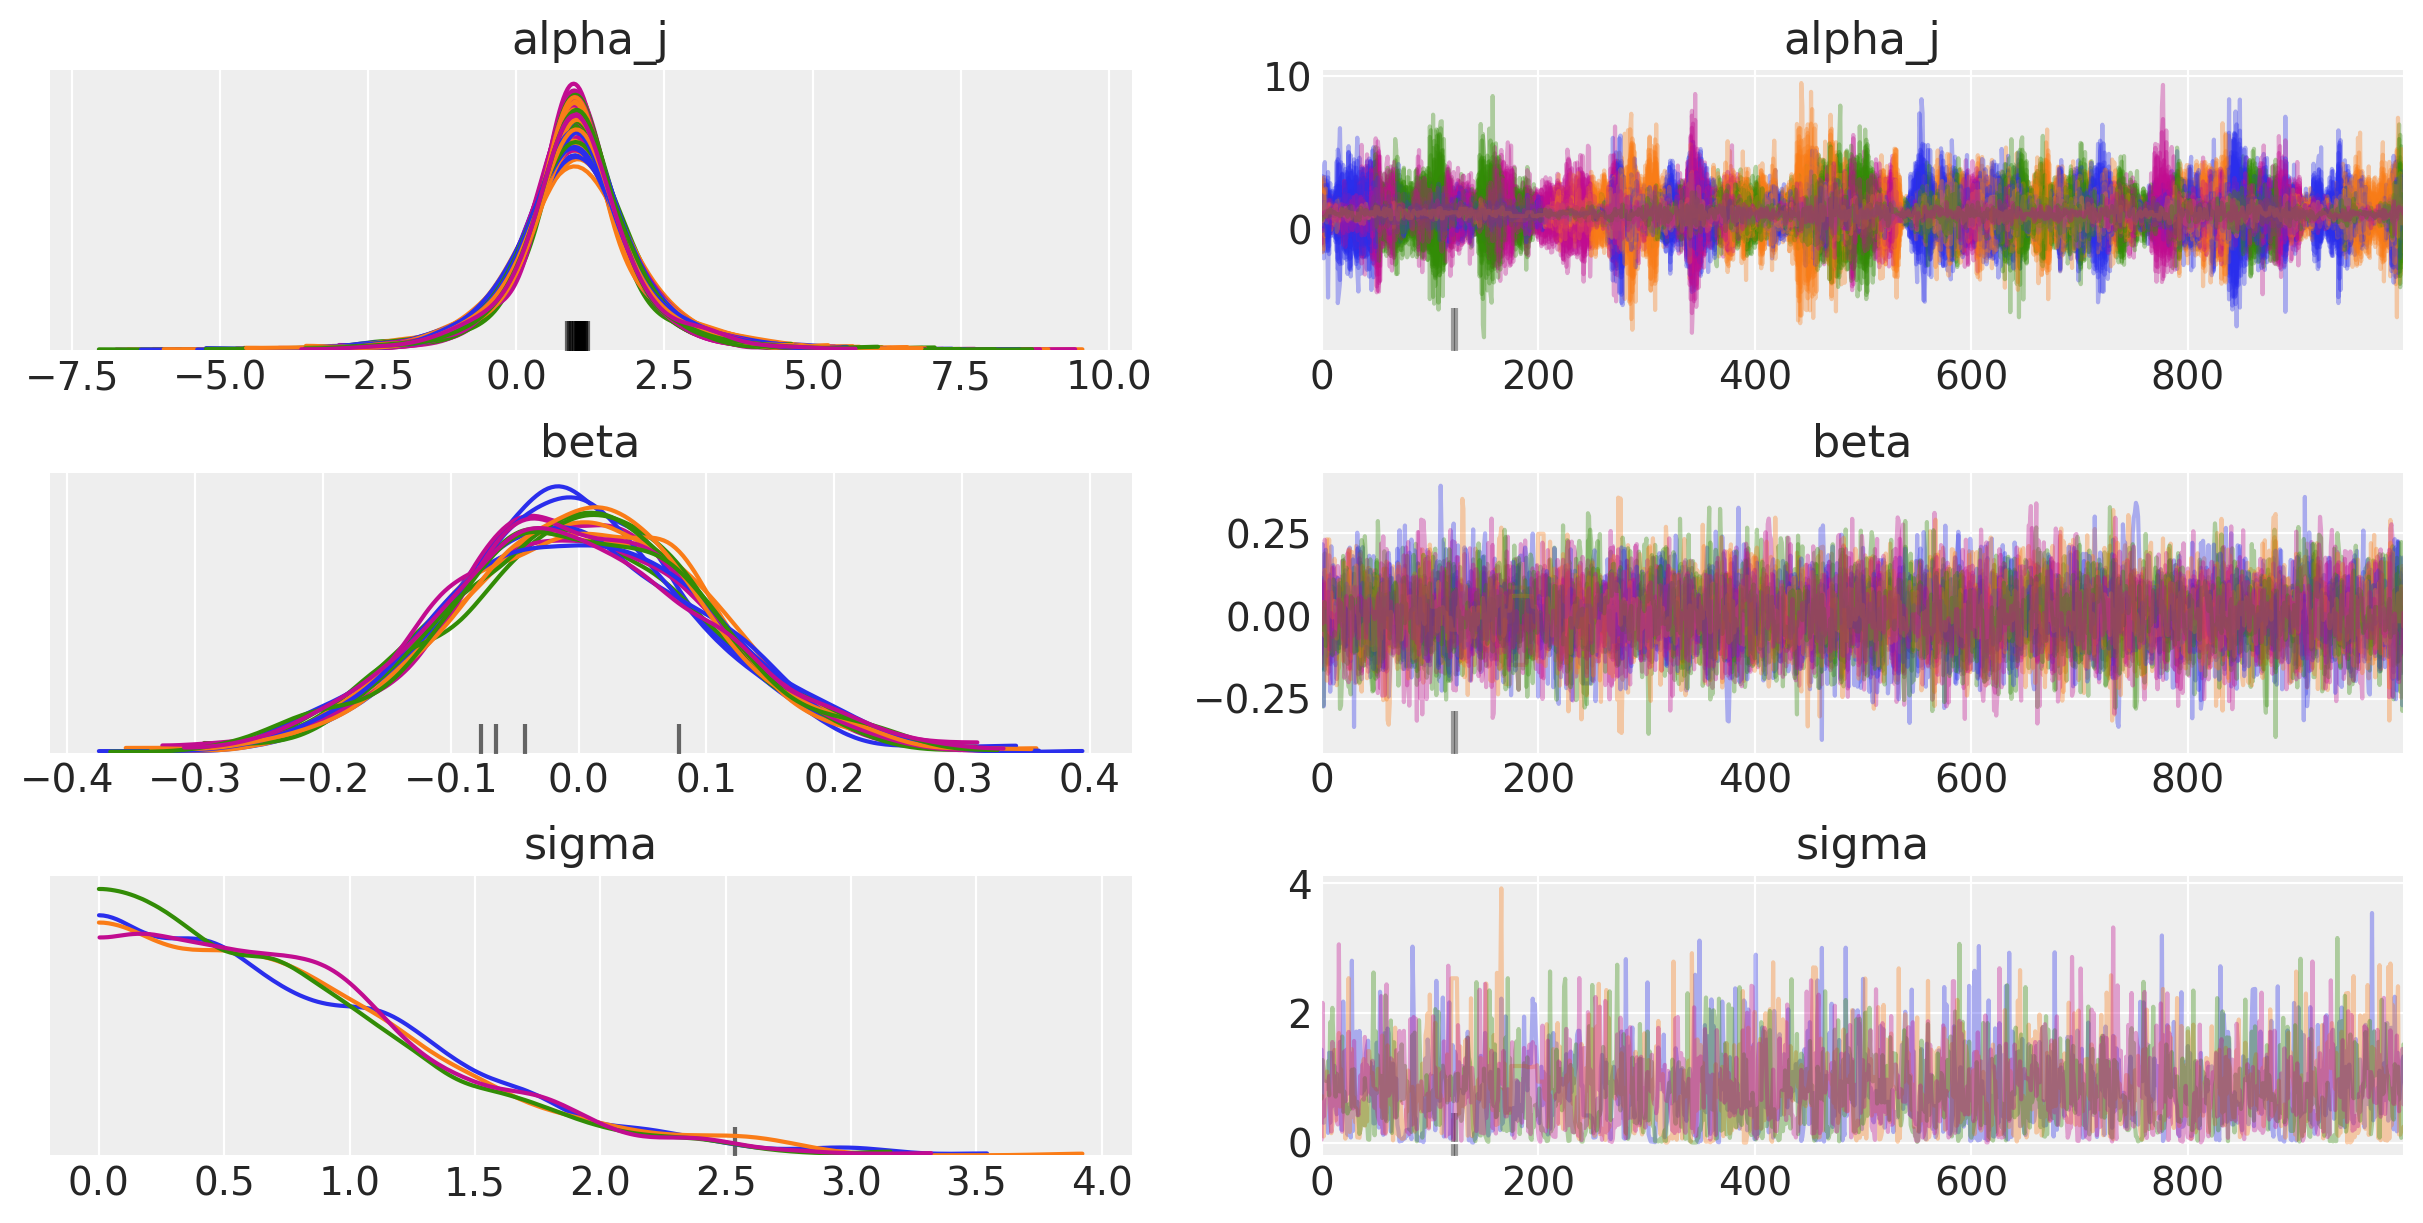

In [49]:
az.plot_trace(fit_model_check, var_names=["alpha_j", "beta", "sigma"], compact = True);

In [ ]:
## Fit model on fake data and recapture known parameters (appendix?)

In [ ]:
## Fit model on real data

In [21]:
data = dict(N = len(train),
            N_test = len(test),
            P = len(X.columns),
            P_test = len(X_test.columns),
            X = X,
            X_test = X_test,
            log_sales_price = train['log_sales_price_std'],
            neighbourhood = train['neighbourhood'],
            N_neighbourhood = len(train['Neighborhood'].unique()),
            neighbourhood_test = test['neighbourhood'],
            run_estimation = 1)

fit_model = multilevel_slopes.sampling(data=data)
df_model = fit_model.to_dataframe()

Process ForkPoolWorker-22:
Process ForkPoolWorker-23:
Process ForkPoolWorker-21:
Process ForkPoolWorker-24:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/benjaminwee/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/benjaminwee/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/benjaminwee/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/benjaminwee/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/benjaminwee/anaconda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/benjaminwee/anaconda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs

KeyboardInterrupt: 

  File "/Users/benjaminwee/anaconda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/Users/benjaminwee/anaconda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/Users/benjaminwee/anaconda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/Users/benjaminwee/anaconda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/Users/benjaminwee/anaconda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/Users/benjaminwee/anaconda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/Users/benjaminwee/anaconda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/Users/benjaminwee/anaconda/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/Users/benjaminwee

In [ ]:
import arviz as az
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

df_model.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False, 
                                                        xlim = (.5, 1.5));

In [ ]:
az.plot_trace(fit_model, var_names=["alpha_j", 'beta', "sigma"], compact = True);

In [ ]:
fig, axes = plt.subplots(1,1)
np.exp(df_model.filter(regex = 'y_hat')*train['log_sales_price'].mean()).T.iloc[:, :300].plot.kde(legend = False, 
                                                                                                  title = 'Posterior predcitve Checks', 
                                                                                                  xlim = (30000,500000),
                                                                                                  alpha = 0.1,
                                                                                                  ax = axes);
train['SalePrice'].plot.kde(legend = False, 
                             xlim = (30000,500000),
                             alpha = 1,
                             ax = axes);

In [10]:
predictions = pd.DataFrame(np.exp(df_model.filter(regex = 'y_test').mean(axis=0)*train['log_sales_price'].mean()),
                  columns = ['SalePrice'])\
                  .reset_index()\
                  .drop('index', axis = 1)

multilevel_extra_csv = pd.concat([test[['Id']].reset_index().drop('index', axis = 1), 
                                   predictions], axis=1)

multilevel_extra_csv.to_csv('../data/submissions/multilevel_extra_int.csv', index = False)

In [11]:
%%sh
cd ../data/submissions/;
kaggle competitions submit -c house-prices-advanced-regression-techniques -f multilevel_extra_int.csv -m "multilevel intercepts plus extra features (conditions, living area, floor sizes)"


Successfully submitted to House Prices: Advanced Regression Techniques

100%|██████████| 33.7k/33.7k [00:05<00:00, 6.86kB/s]
